In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/additional_data_cleaned_ER.csv')
df = df.dropna()
df.shape

(12975, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12975 entries, 0 to 12974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12975 non-null  int64  
 1   house_type    12975 non-null  object 
 2   house_type_2  12521 non-null  object 
 3   rooms         12975 non-null  int64  
 4   m2            12975 non-null  float64
 5   elevator      12975 non-null  int64  
 6   garage        12975 non-null  int64  
 7   neighborhood  12975 non-null  object 
 8   district      12975 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 912.4+ KB


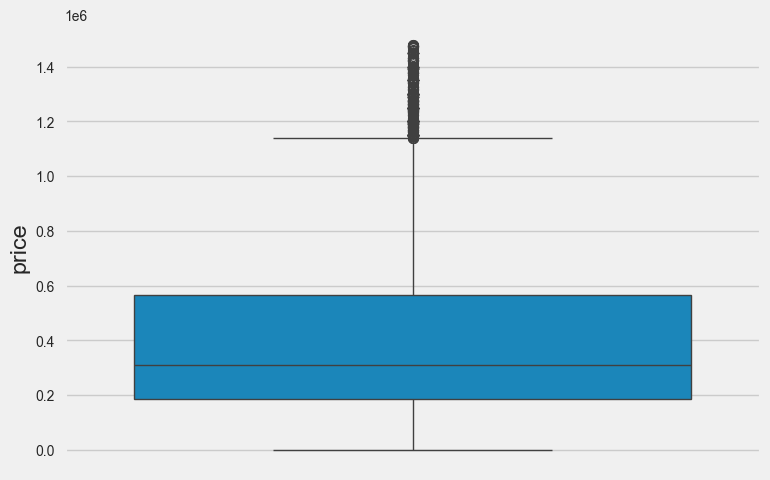

In [6]:
sns.boxplot(df['price'])
plt.show()

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12975 entries, 0 to 12974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12975 non-null  int64  
 1   house_type    12975 non-null  object 
 2   house_type_2  12521 non-null  object 
 3   rooms         12975 non-null  int64  
 4   m2            12975 non-null  float64
 5   elevator      12975 non-null  int64  
 6   garage        12975 non-null  int64  
 7   neighborhood  12975 non-null  object 
 8   district      12975 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 912.4+ KB


In [10]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.773151
rooms,0.490906
elevator,0.363338
garage,0.274575


In [12]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [13]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Initialize models
logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

ridge_classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

lasso_logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='saga'))
])

elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

# Train and evaluate


In [14]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'price',
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore'
)

,Description,Value
0,Session id,1974
1,Target,price
2,Target type,Regression
3,Original data shape,"(12975, 9)"
4,Transformed data shape,"(12975, 29)"
5,Transformed train set shape,"(9082, 29)"
6,Transformed test set shape,"(3893, 29)"
7,Numeric features,4
8,Categorical features,4
9,Rows with missing values,3.5%


In [15]:
# compare baseline models
# best_model = compare_models(exclude=['lar'])

In [16]:
n_iter=50

# print('Tune Model:')
# best_model = tune_model(best_model, n_iter=n_iter, choose_better=True)

# print('Tune Model - optuna:')
# best_model = tune_model(best_model, search_library = 'optuna', n_iter=n_iter, choose_better=True)

# print('Tune Model - scikit-optimize:')
# best_model = tune_model(best_model, search_library = 'scikit-optimize', n_iter=n_iter, choose_better=True)

# print('Bagging:')
# best_model = ensemble_model(best_model, method = 'Bagging', choose_better=True)

# print('Boosting:')
# best_model = ensemble_model(best_model, method = 'Boosting', choose_better=True)

print('Top 3 Models:')
best_mae_models_top3 = compare_models(sort = 'MAE', n_select = 3)

# print('Blending:')
# best_model = blend_models(best_mae_models_top3, choose_better=True)

print('Stacking:')
best_model = stack_models(best_mae_models_top3, choose_better=True)

Top 3 Models:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,62962.1025,9384326484.9269,96735.9671,0.9040,0.2106,0.1888,0.2680
et,Extra Trees Regressor,63595.3896,10417654888.2689,101928.2320,0.8934,0.2204,0.1906,0.2020
xgboost,Extreme Gradient Boosting,64692.4409,10212953985.4322,100900.1828,0.8955,0.2149,0.1901,0.0530
lightgbm,Light Gradient Boosting Machine,65129.8963,10032028227.5043,100013.3089,0.8974,0.2168,0.1941,0.5630
rf,Random Forest Regressor,65371.4850,10644930200.8912,103011.8387,0.8912,0.2221,0.1960,0.2200
gbr,Gradient Boosting Regressor,71616.7065,11647555181.1563,107776.0531,0.8809,0.2365,0.2146,0.0820
knn,K Neighbors Regressor,77280.6216,14627243813.8750,120752.1128,0.8503,0.2506,0.2197,0.0400
dt,Decision Tree Regressor,83727.0375,18818832984.9773,137060.3556,0.8073,0.2991,0.2476,0.0330
par,Passive Aggressive Regressor,101027.0351,22314594827.9200,149273.3082,0.7716,0.5037,0.3127,0.0650
huber,Huber Regressor,101162.0288,21544338355.4519,146680.1455,0.7795,0.5397,0.3234,0.0320


Stacking:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61061.9684,8431539635.2059,91823.4155,0.9147,0.1883,0.1518
1,62563.9399,9526980199.7359,97606.2508,0.9016,0.1927,0.1521
2,60913.8580,10058055171.0719,100289.8558,0.8985,0.1933,0.1488
3,63678.2340,10583271319.4619,102875.0277,0.8974,0.2015,0.1525
4,62907.1089,9120855590.5009,95503.1706,0.9052,0.2046,0.1630
5,60566.9471,8990075074.4975,94816.0064,0.9026,0.1981,0.1561
6,66076.4965,10100900128.6225,100503.2344,0.9024,0.2085,0.1626
7,59550.1054,9180016836.8747,95812.4044,0.9053,0.2127,0.1646
8,58639.0830,7971718546.5576,89284.4810,0.9191,0.2644,0.4222


In [17]:
holdout_pred = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,58497.9536,8280847025.9434,90999.1595,0.9112,0.1946,0.1511


In [18]:
holdout_pred.describe()

,rooms,m2,elevator,garage,price,prediction_label
count,3893.000000,3893.000000,3893.000000,3893.000000,3.893000e+03,3.893000e+03
mean,2.662985,102.112511,0.691754,0.256101,4.179593e+05,4.183675e+05
std,1.141328,58.770298,0.461828,0.436534,3.054098e+05,2.936835e+05
min,1.000000,20.000000,0.000000,0.000000,5.510000e+04,6.837204e+04
25%,2.000000,64.000000,0.000000,0.000000,1.820000e+05,1.905624e+05
50%,3.000000,86.000000,1.000000,0.000000,3.100000e+05,3.097836e+05
75%,3.000000,120.000000,1.000000,1.000000,5.650000e+05,5.671871e+05
max,11.000000,700.000000,1.000000,1.000000,1.475000e+06,1.432116e+06


In [19]:
RMSE = np.sqrt(mean_squared_error(holdout_pred['price'], holdout_pred['prediction_label']))
RMSE/(holdout_pred['price'].max() - holdout_pred['price'].min())

0.0640884283958897

In [20]:
evaluate_model(best_model, fold=10)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

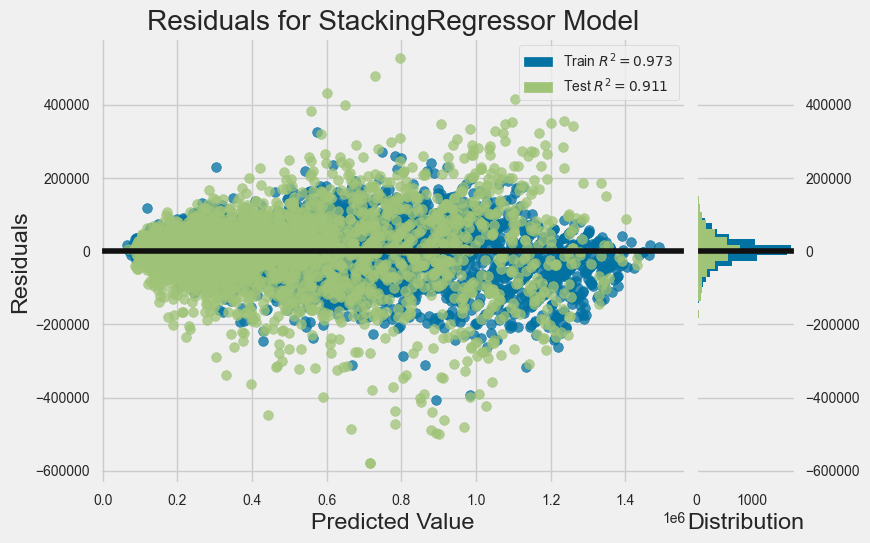

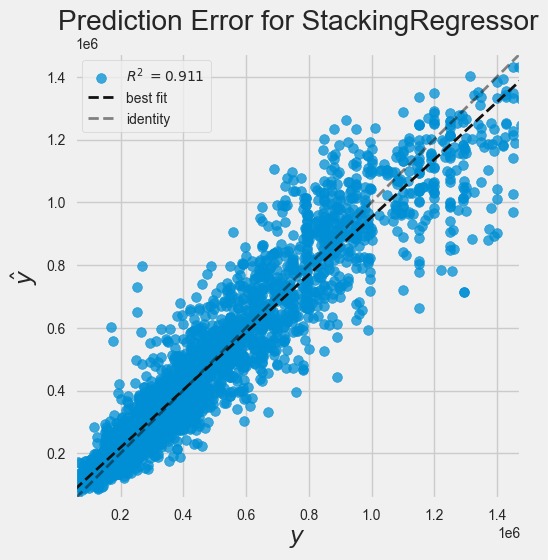

In [21]:
plot_model(best_model, plot = 'residuals', fold=10)

plot_model(best_model, plot = 'error')

# plot_model(best_model, plot = 'feature')

# plot_model(best_model, plot = 'learning')

<Axes: >

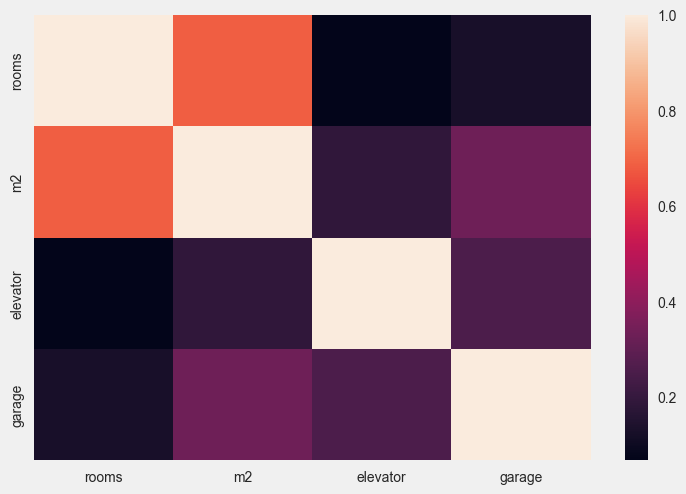

In [22]:
sns.heatmap(df[numerical_features].corr())

K =  2 	WCSS Err. =  48173.378394749016
K =  3 	WCSS Err. =  37254.03714880373
K =  4 	WCSS Err. =  29324.420240919993
K =  5 	WCSS Err. =  27754.237406317177
K =  6 	WCSS Err. =  25968.268922024734
K =  7 	WCSS Err. =  22905.2559153248
K =  8 	WCSS Err. =  21130.95795986602
K =  9 	WCSS Err. =  19618.143277915704
K =  10 	WCSS Err. =  18588.953613691865


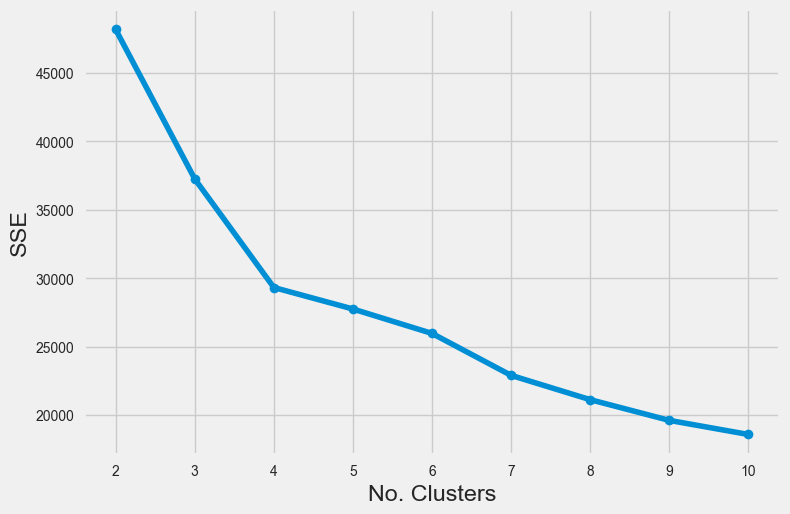

In [23]:
cluster_errors = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))
    ])
    kmeans_pipeline.fit(X)
    wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
    print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)
    cluster_errors.append(wcsse)

plt.plot(range(2, 11), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("SSE")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3088
For n_clusters = 3 The average silhouette_score is : 0.3851
For n_clusters = 4 The average silhouette_score is : 0.4997
For n_clusters = 5 The average silhouette_score is : 0.4461
For n_clusters = 6 The average silhouette_score is : 0.4145
For n_clusters = 7 The average silhouette_score is : 0.4077
For n_clusters = 8 The average silhouette_score is : 0.3629
For n_clusters = 9 The average silhouette_score is : 0.4259
For n_clusters = 10 The average silhouette_score is : 0.382


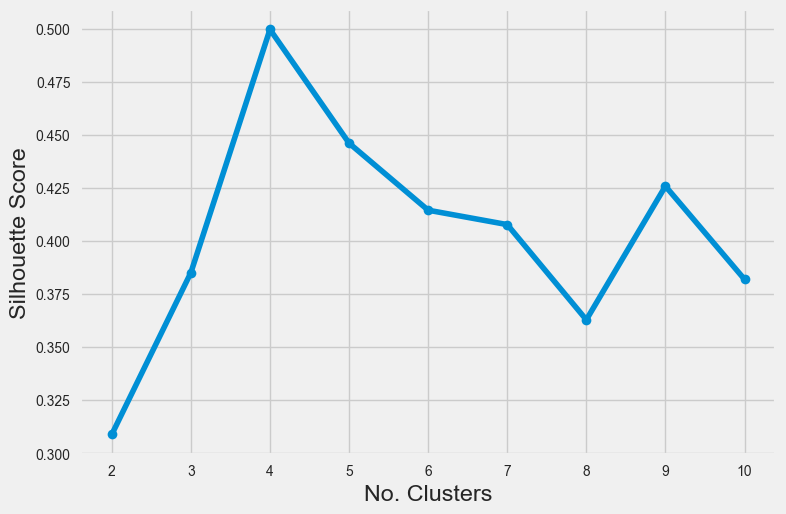

In [24]:
silhouette_s = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters))])
    df_X = kmeans_pipeline.fit_transform(X)
    cluster_labels = kmeans_pipeline.fit_predict(X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(df_X, cluster_labels))

plt.plot(range(2, 11),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()


In [25]:
pipe_pca_kmean = Pipeline(
        [
          ('preprocessor', preprocessor),
          ('pca', PCA(10, svd_solver='arpack')),
          ("cluster", KMeans(n_clusters=3, verbose=0))
        ]
    )
pipe_pca_kmean.fit(X)
pipe_pca_kmean.predict(X)

array([1, 1, 0, ..., 0, 0, 2], dtype=int32)

In [26]:
kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index = X.index,
    columns=['kmean_cluster']
)

In [27]:
# kmean_cluster
cluster_labels

array([1, 9, 0, ..., 0, 0, 3], dtype=int32)

In [28]:
kmean_cluster['kmean_cluster'].value_counts()

2    5994
0    3589
1    3392
Name: kmean_cluster, dtype: int64

In [29]:
X['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [30]:
df['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [31]:
df['price'] = df['price'].apply(lambda x: round(x, 2))
pd.options.display.float_format = '{:.2f}'.format

df_combined_describe_dict = {}
columns = []

df_0 = df[df['kmean_cluster']==0]
df_0_y_describe = df_0['price'].describe()
df_combined_describe_dict['df_0'] = df_0_y_describe
columns.append(('Price', 'Cluster 0'))

df_1 = df[df['kmean_cluster']==1]
df_1_y_describe = df_1['price'].describe()
df_combined_describe_dict['df_1'] = df_1_y_describe
columns.append(('Price', 'Cluster 1'))

df_2 = df[df['kmean_cluster']==2]
df_2_y_describe = df_2['price'].describe()
df_combined_describe_dict['df_2'] = df_2_y_describe
columns.append(('Price', 'Cluster 2'))

df_combined_describe = pd.DataFrame(df_combined_describe_dict)

multi_index = pd.MultiIndex.from_tuples(columns)

df_combined_describe.columns = multi_index

df_combined_describe

Price                      
       Cluster 0  Cluster 1  Cluster 2
count    3589.00    3392.00    5994.00
mean   209657.83  587664.70  455448.12
std    150265.65  329780.61  300035.79
min     47500.00   75000.00     725.00
25%    133000.00  325000.00  229000.00
50%    164999.00  485000.00  360000.00
75%    225000.00  806250.00  610000.00
max   1395000.00 1480000.00 1480000.00

In [32]:
tsne = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("tsne", TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init='random')),
        ]
    )

X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12975 samples in 0.001s...
[t-SNE] Computed neighbors for 12975 samples in 3.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12975
[t-SNE] Computed conditional probabilities for sample 2000 / 12975
[t-SNE] Computed conditional probabilities for sample 3000 / 12975
[t-SNE] Computed conditional probabilities for sample 4000 / 12975
[t-SNE] Computed conditional probabilities for sample 5000 / 12975
[t-SNE] Computed conditional probabilities for sample 6000 / 12975
[t-SNE] Computed conditional probabilities for sample 7000 / 12975
[t-SNE] Computed conditional probabilities for sample 8000 / 12975
[t-SNE] Computed conditional probabilities for sample 9000 / 12975
[t-SNE] Computed conditional probabilities for sample 10000 / 12975
[t-SNE] Computed conditional probabilities for sample 11000 / 12975
[t-SNE] Computed conditional probabilities for sample 12000 / 12975
[t-SNE] Computed conditional probabilities for sa

In [33]:
le = LabelEncoder()

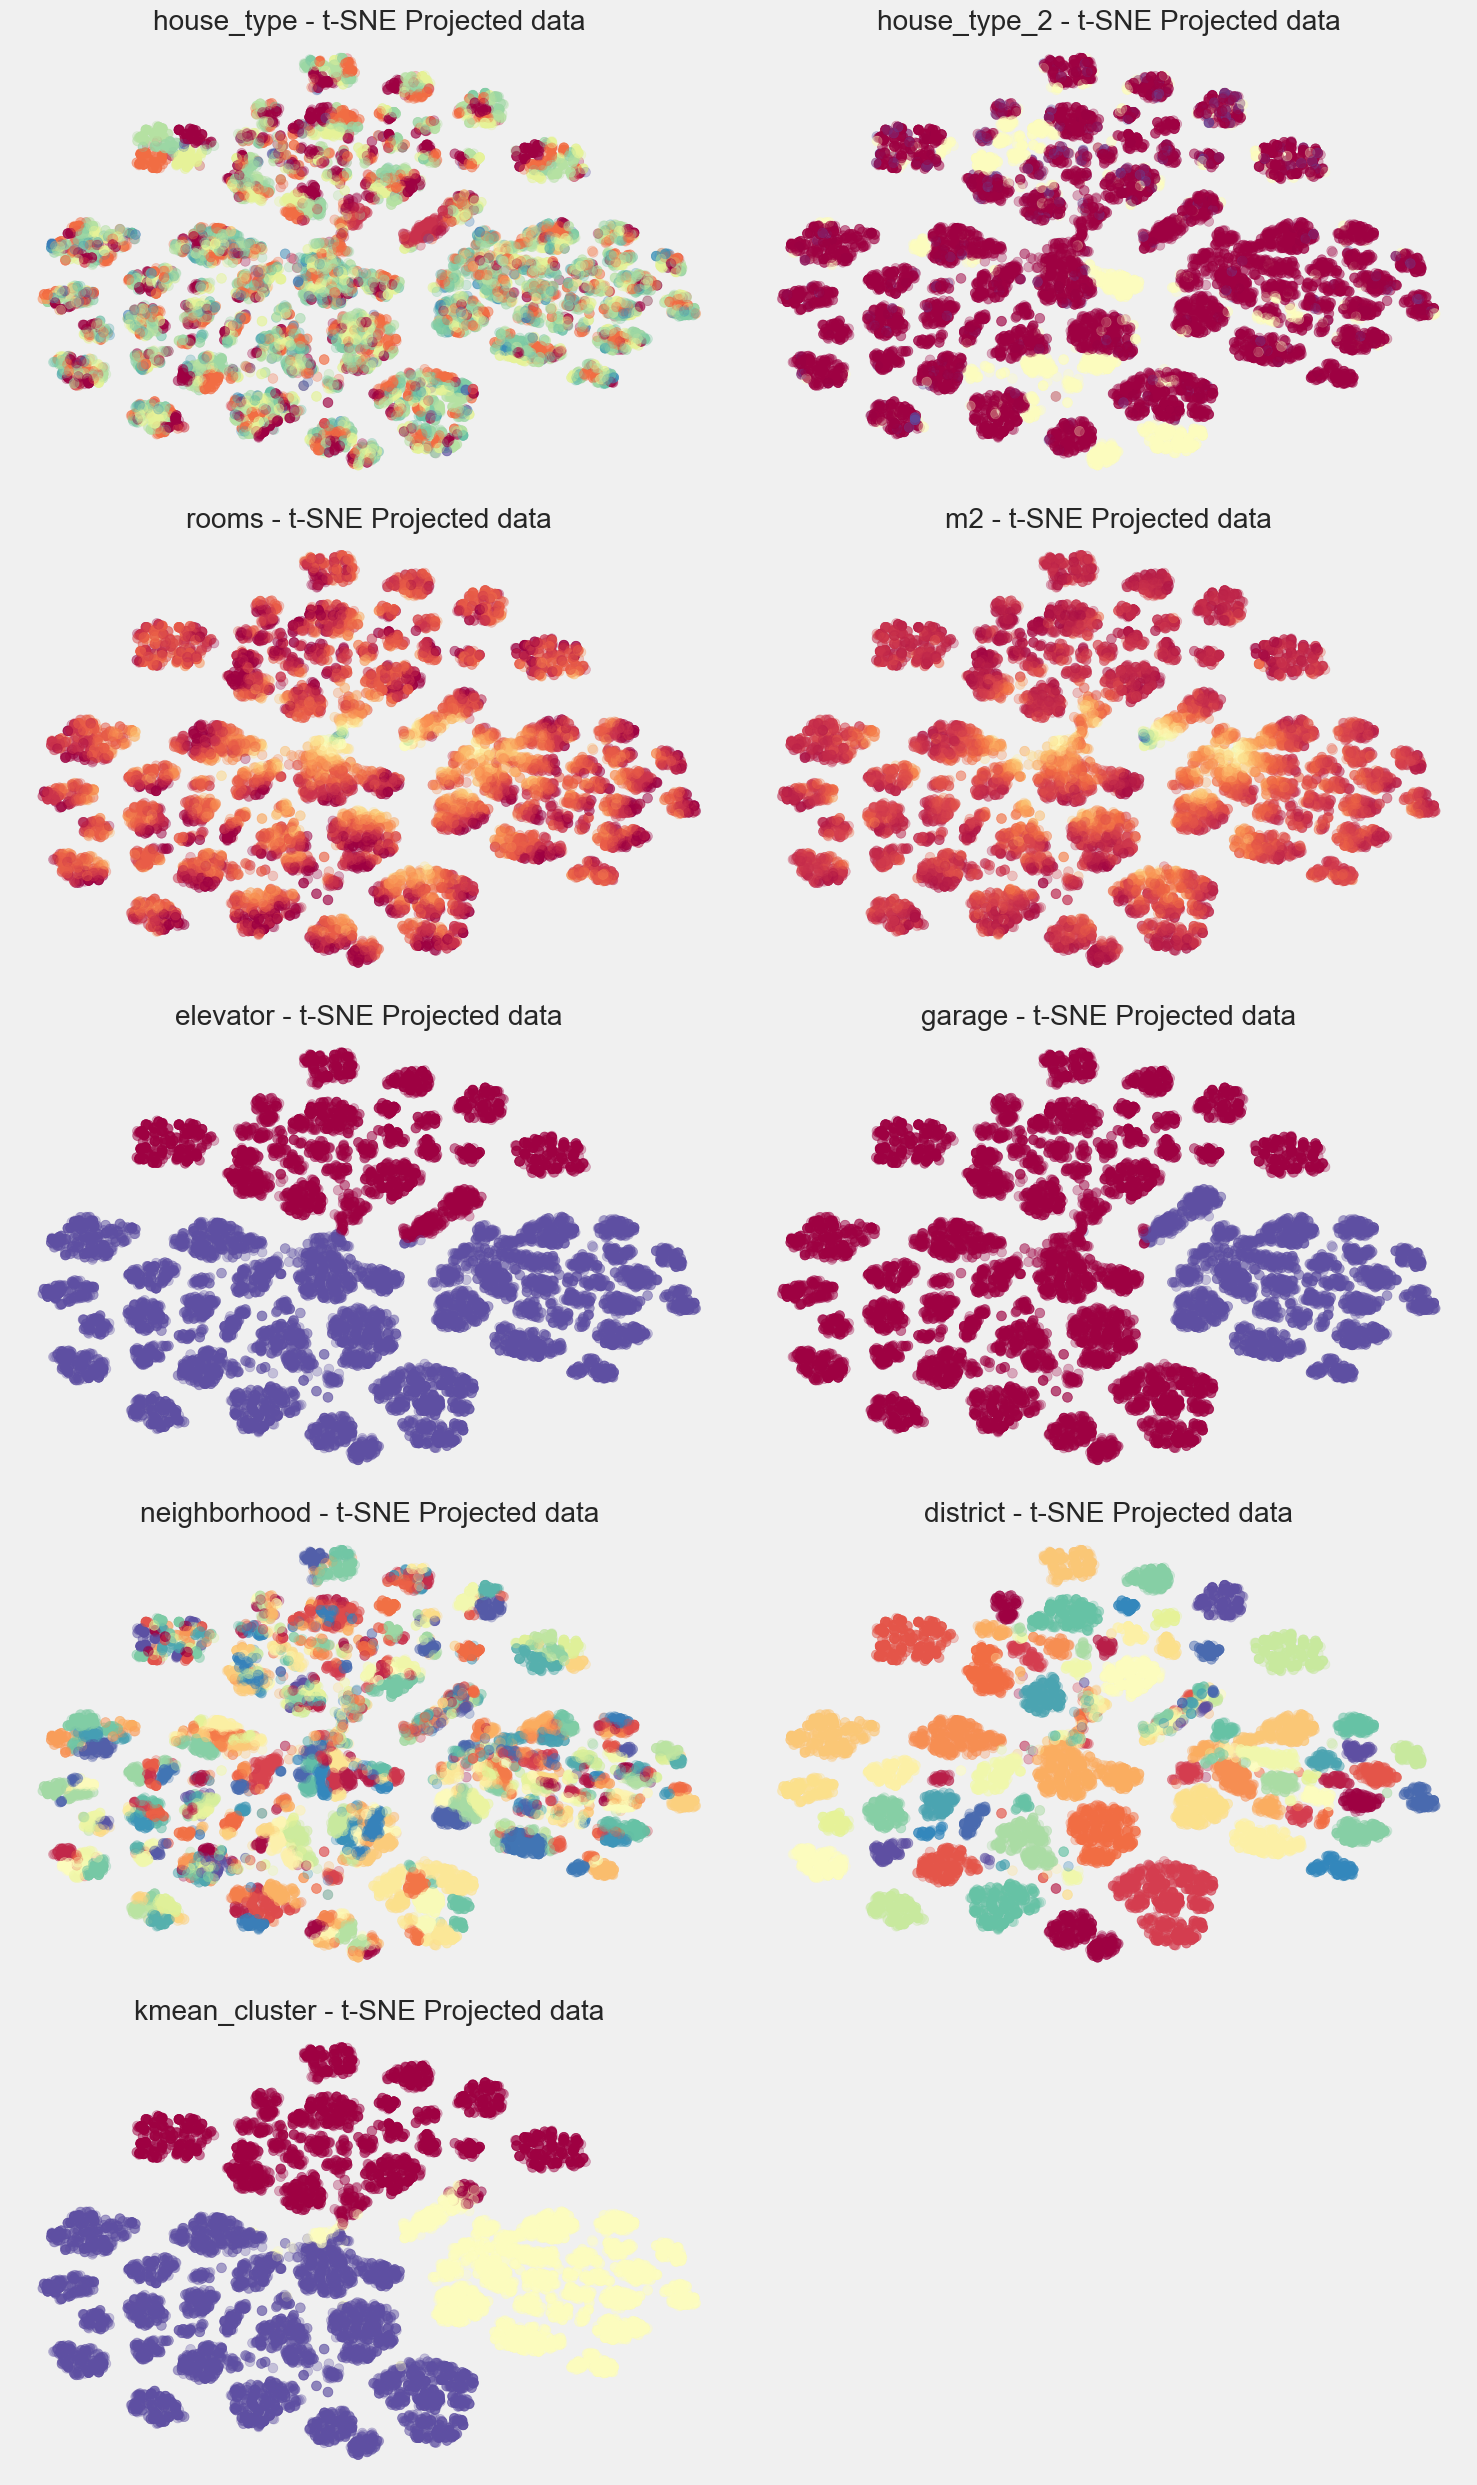

In [34]:
nrows = 8
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15, 40))

axs = axs.flatten()

le = LabelEncoder()

for i, column in enumerate(X.columns):
    if i >= len(axs):
        break
    ax = axs[i]
    if column in categorical_features:
        encoded_column = le.fit_transform(df[column])
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=plt.cm.Spectral, alpha=0.3)
    else:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[column], cmap=plt.cm.Spectral, alpha=0.3)

    ax.set_title(f'{column} - t-SNE Projected data')
    ax.axis('tight')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [35]:
df_0.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district', 'kmean_cluster'],
      dtype='object')

In [36]:
num_features_plot = ['price', 'm2']

In [37]:
def plot_clusters(column, df_list, numerical_features, figsize, rotate=False):
    print(rotate)
    if column in numerical_features:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        for i, df in enumerate(df_list):
            sns.kdeplot(data=df, x=column, ax=ax, label=f'Cluster {i}', shade=True)
        ax.set_title(f'KDE Plot - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()
        if rotate:
            plt.xticks(rotation=360)
    else:
        cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
        combined_df = pd.concat([df.assign(cluster=i) for i, df in enumerate(df_list)])
        proportions = combined_df.groupby([column, 'cluster']).size().reset_index(name='count')
        proportions['proportion'] = proportions.groupby(column)['count'].apply(lambda x: x / float(x.sum()))
        pivot_df = proportions.pivot(index=column, columns='cluster', values='proportion').fillna(0)
        pivot_df = pivot_df.sort_values(by=0)
        fig, ax = plt.subplots(figsize=figsize)
        pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cluster_colors[:pivot_df.shape[1]])
        ax.set_title(f'Relative Proportions - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        if rotate:
            plt.xticks(rotation=90)
        else:
            plt.xticks(rotation=0)
    plt.show()

False


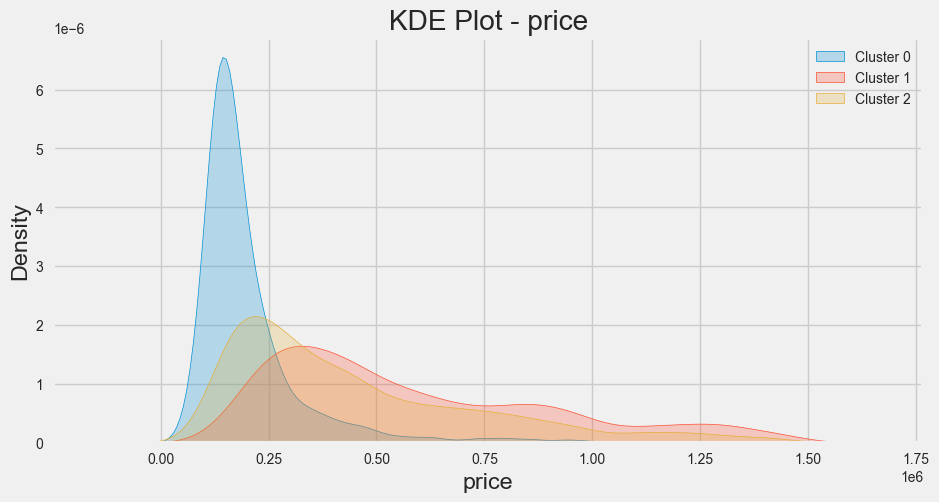

In [38]:
plot_clusters('price', [df_0, df_1, df_2], num_features_plot, (10,5))

False


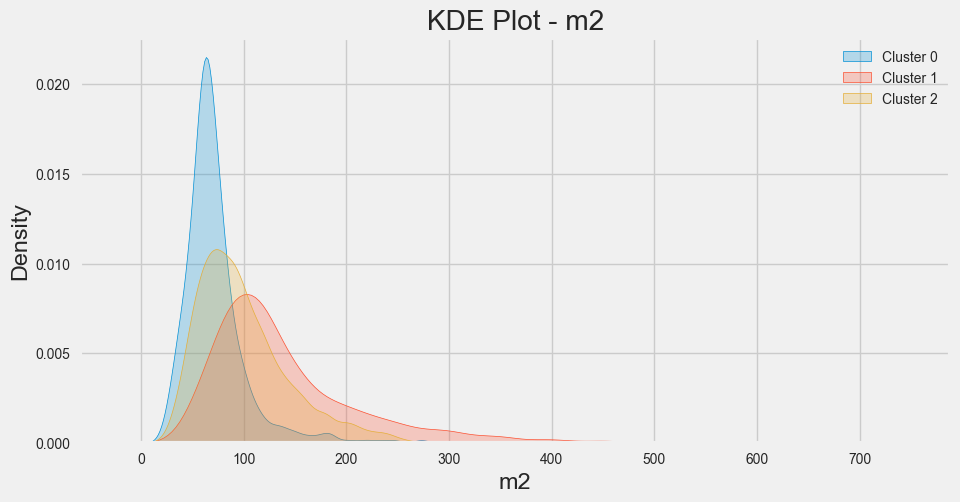

In [39]:
plot_clusters('m2', [df_0, df_1, df_2], num_features_plot, (10,5))

True


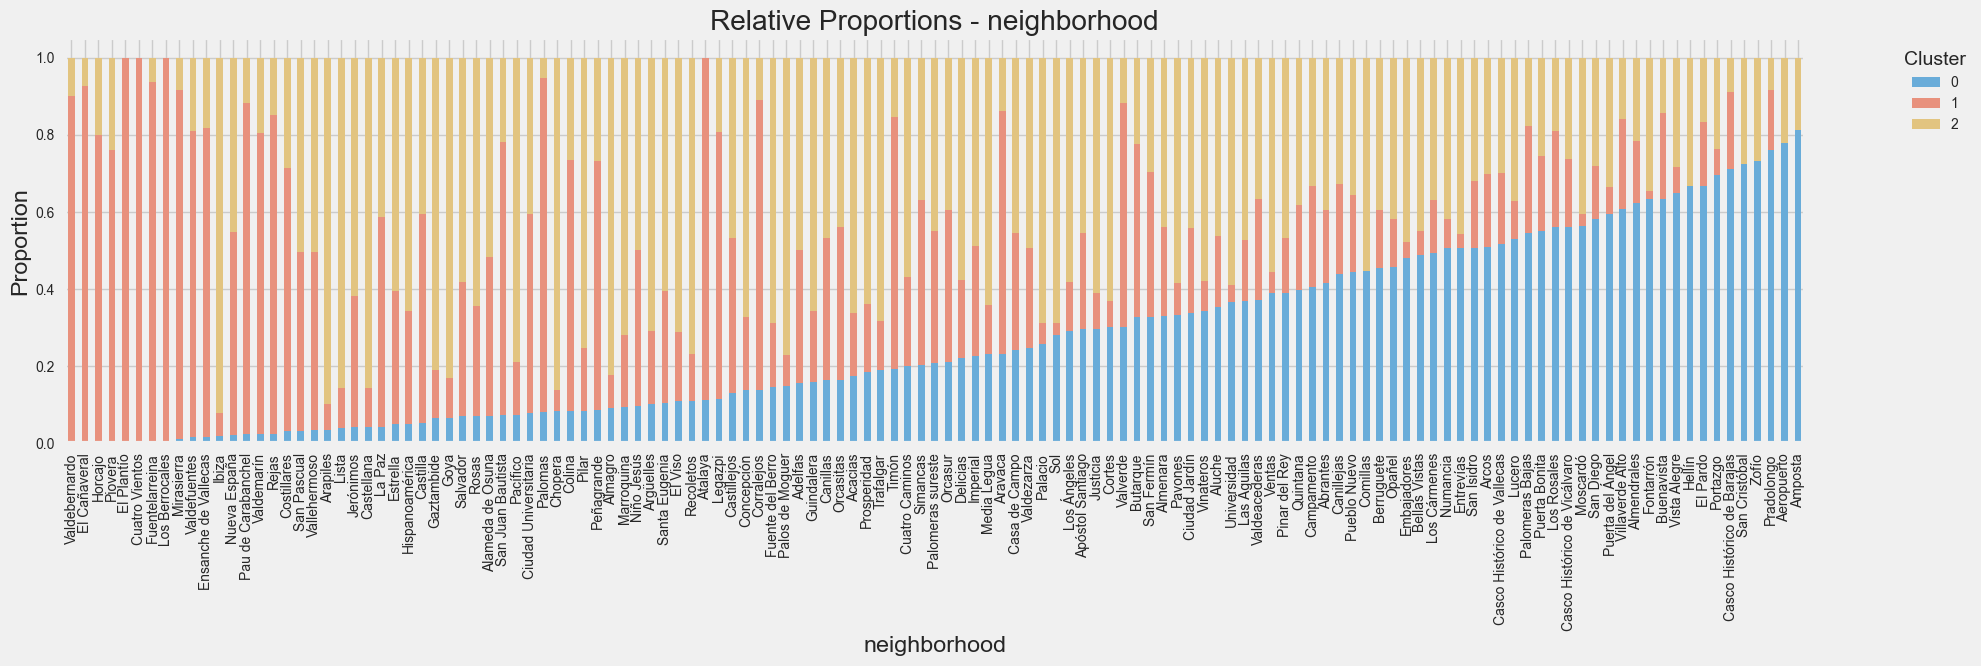

In [40]:
plot_clusters('neighborhood', [df_0, df_1, df_2], num_features_plot, (20, 5), True)

In [41]:
df_0 = df_0.drop(columns='kmean_cluster')
df_1 = df_1.drop(columns='kmean_cluster')
df_2 = df_2.drop(columns='kmean_cluster')


In [42]:
df_0.to_csv('../data/processed/additional_data_cluster_0.csv', index=False)
df_1.to_csv('../data/processed/additional_data_cluster_1.csv', index=False)
df_2.to_csv('../data/processed/additional_data_cluster_2.csv', index=False)